In [3]:
import pickle
import os

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import networkx as nx

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../src/")

from classifiers.features import get_distances, get_configuration_distances_feature, get_labels, format_feature_matrix
from classifiers.logreg import *
from data.observations import get_preprocessed_data

# Loading cache and applying transformations

In [4]:
drosophila = get_preprocessed_data("drosophila", [1, 2], 0.23, 1)
drosophila.embeddings = drosophila.renormalize()
drosophila.embeddings = drosophila.align_centers()

# Computing features

In [7]:
distances_G_train, distances_H_train = \
    get_distances(drosophila.embeddings, list(drosophila.observed_edges.keys()))
distances_G_test, distances_H_test = \
    get_distances(drosophila.embeddings, list(drosophila.unobserved_edges.keys()))

d_train = get_configuration_distances_feature(distances_G_train, distances_H_train, tilde=False)
d_test = get_configuration_distances_feature(distances_G_test, distances_H_test, tilde=False)
dtilde_train = get_configuration_distances_feature(distances_G_train, distances_H_train, tilde=True)
dtilde_test = get_configuration_distances_feature(distances_G_test, distances_H_test, tilde=True)

In [8]:
data ={}
for idx, (edge, class_) in enumerate(drosophila.observed_edges.items()):
    d = d_train[idx]
    dtilde = dtilde_train[idx]
    data[edge] = (class_, d, dtilde, "train")
for idx, (edge, class_) in enumerate(drosophila.unobserved_edges.items()):
    d = d_test[idx]
    dtilde = dtilde_test[idx]
    data[edge] = (class_, d, dtilde, "test")

In [9]:
data_train = {k: v for k, v in data.items() if v[-1] == "train"}
data_test = {k: v for k, v in data.items() if v[-1] == "test"}

In [10]:
data_train_correct_d = {k: v for k, v in data_train.items() if v[0] == 1 and v[1] >= 0.5}
data_test_correct_d = {k: v for k, v in data_test.items() if v[0] == 1 and v[1] >= 0.5}
data_train_correct_dtilde = {k: v for k, v in data_train.items() if v[0] == 1 and v[2] <= 0.5}
data_test_correct_dtilde = {k: v for k, v in data_test.items() if v[0] == 1 and v[2] <= 0.5}

# Training logistic regression model

In [40]:
feature_matrix_train, feature_matrix_test = \
    format_feature_matrix(
        {"emb"},
        len(drosophila.observed_edges), len(drosophila.unobserved_edges),
        d_train, d_test,
        None, None
    )
labels_train, labels_test = get_labels(
    drosophila.observed_edges, drosophila.unobserved_edges
)

model = train_fit_logreg(feature_matrix_train, labels_train, {})

accuracy = get_model_accuracy(model, feature_matrix_test, labels_test)
auroc = get_model_auroc(model, feature_matrix_test, labels_test)
aupr = get_model_aupr(model, feature_matrix_test, labels_test)
intercept, coefficients = get_model_fit(model)

print("Configuration distance feature")
print(f"AUROC: {auroc:.4f}")

print(f"Intercept = {intercept[0]}, coefficient = {coefficients[0][0]}")

Configuration distance feature
AUROC: 0.1812
Intercept = 2.1953803652173116, coefficient = 12.300158111200375


In [42]:
feature_matrix_train, feature_matrix_test = \
    format_feature_matrix(
        {"emb"},
        len(drosophila.observed_edges), len(drosophila.unobserved_edges),
        dtilde_train, dtilde_test,
        None, None
    )
labels_train, labels_test = get_labels(
    drosophila.observed_edges, drosophila.unobserved_edges
)

model = train_fit_logreg(feature_matrix_train, labels_train, {})

accuracy = get_model_accuracy(model, feature_matrix_test, labels_test)
auroc = get_model_auroc(model, feature_matrix_test, labels_test)
aupr = get_model_aupr(model, feature_matrix_test, labels_test)
intercept, coefficients = get_model_fit(model)

print("Ratio distance feature")
print(f"AUROC: {auroc:.4f}")

print(f"Intercept = {intercept[0]}, coefficient = {coefficients[0][0]}")

Ratio distance feature
AUROC: 0.8141
Intercept = 2.946888861135142, coefficient = 0.024029992921931198


# Some visualizations

Text(0.5, 1.0, 'Classified by configuration distance\n Train data')

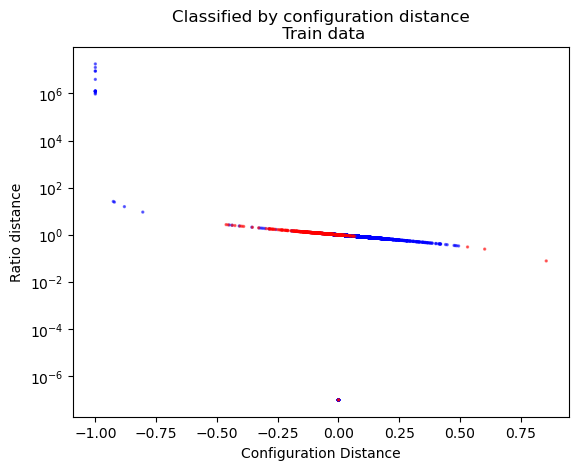

In [52]:
x_ = [v[1] for v in data_train.values()]
y_ = [v[2] for v in data_train.values()]
colors_ = ["blue" if v[0] == 1 and v[1] <= 0.5 else "red" for v in data_train.values()]

plt.scatter(x_, y_, c=colors_, s=2, alpha=0.5)
plt.yscale("log")

plt.xlabel("Configuration Distance")
plt.ylabel("Ratio distance")
plt.title("Classified by configuration distance\n Train data")

Text(0.5, 1.0, 'Classified by ratio distance\n Train data')

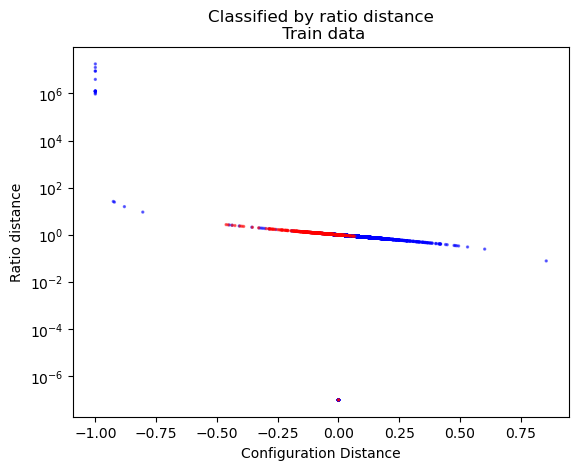

In [53]:
x_ = [v[1] for v in data_train.values()]
y_ = [v[2] for v in data_train.values()]
colors_ = ["blue" if v[0] == 1 and model.predict(v[2].reshape(-1,1)) == 1 else "red" for v in data_train.values()]

plt.scatter(x_, y_, c=colors_, s=2, alpha=0.5)
plt.yscale("log")

plt.xlabel("Configuration Distance")
plt.ylabel("Ratio distance")
plt.title("Classified by ratio distance\n Train data")

Text(0.5, 1.0, 'Classified by configuration distance\n Test data')

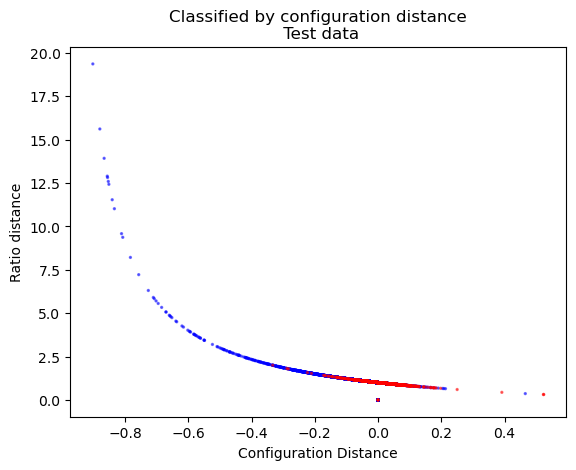

In [57]:
x_ = [v[1] for v in data_test.values()]
y_ = [v[2] for v in data_test.values()]
colors_ = ["blue" if v[0] == 1 and v[1] <= 0.5 else "red" for v in data_test.values()]

plt.scatter(x_, y_, c=colors_, s=2, alpha=0.5)
# plt.yscale("log")

plt.xlabel("Configuration Distance")
plt.ylabel("Ratio distance")
plt.title("Classified by configuration distance\n Test data")

Text(0.5, 1.0, 'Classified by ratio distance\n Test data')

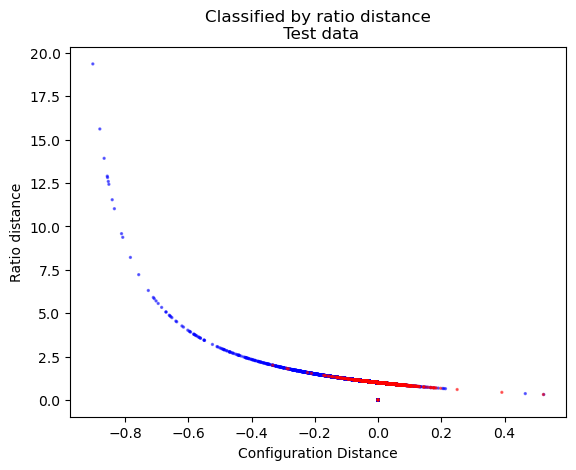

In [56]:
x_ = [v[1] for v in data_test.values()]
y_ = [v[2] for v in data_test.values()]
colors_ = ["blue" if v[0] == 1 and model.predict(v[2].reshape(-1,1)) == 1 else "red" for v in data_test.values()]

plt.scatter(x_, y_, c=colors_, s=2, alpha=0.5)
# plt.yscale("log")

plt.xlabel("Configuration Distance")
plt.ylabel("Ratio distance")
plt.title("Classified by ratio distance\n Test data")

Text(0.5, 1.0, 'Classified by configuration distance\n Test data - Colored by g.t.')

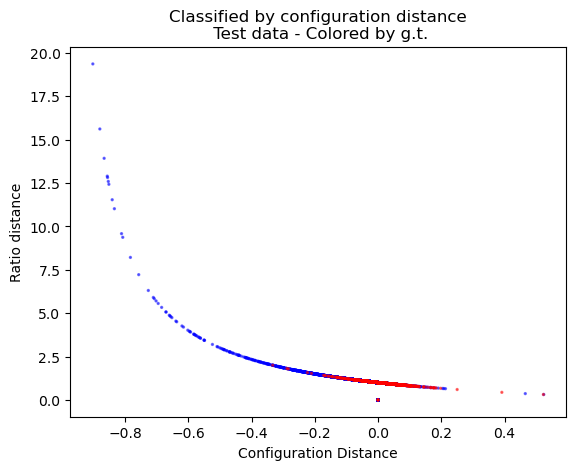

In [58]:
x_ = [v[1] for v in data_test.values()]
y_ = [v[2] for v in data_test.values()]
colors_ = ["blue" if v[0] == 1 else "red" for v in data_test.values()]

plt.scatter(x_, y_, c=colors_, s=2, alpha=0.5)
# plt.yscale("log")

plt.xlabel("Configuration Distance")
plt.ylabel("Ratio distance")
plt.title("Classified by configuration distance\n Test data - Colored by g.t.")

Text(0.5, 1.0, 'Classified by configuration distance\n Train data - Colored by g.t.')

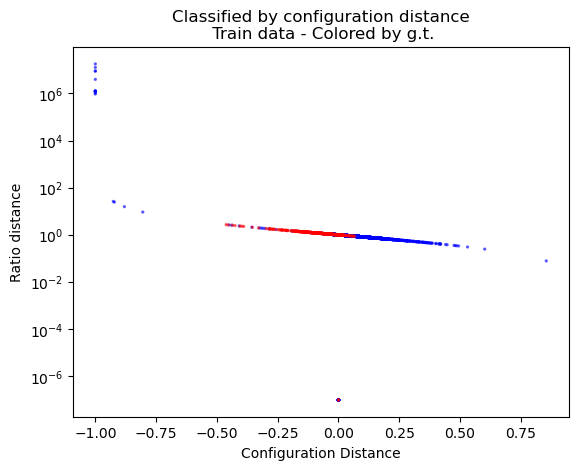

In [60]:
x_ = [v[1] for v in data_train.values()]
y_ = [v[2] for v in data_train.values()]
colors_ = ["blue" if v[0] == 1 else "red" for v in data_train.values()]

plt.scatter(x_, y_, c=colors_, s=2, alpha=0.5)
plt.yscale("log")

plt.xlabel("Configuration Distance")
plt.ylabel("Ratio distance")
plt.title("Classified by configuration distance\n Train data - Colored by g.t.")